# Извлечение отзывов

In [ ]:
!pip install vk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import getpass
import time
from collections import defaultdict

import vk
from vk.exceptions import VkAPIError

from tqdm.notebook import tqdm

api = vk.API(access_token=getpass.getpass())

In [ ]:
class RequestWithSleep:
    def __init__(self, max_calls_per_second=3, sleep_time=1):
        self.max_calls_per_second = max_calls_per_second
        self.sleep_time = sleep_time
        self.counter = 0
    
    def request(self, method, **kwargs):
        if self.counter % self.max_calls_per_second == 0:
            time.sleep(self.sleep_time)
        self.counter += 1
        return method(**kwargs)

requester = RequestWithSleep()

In [ ]:
APIVersion = 5.131

total_users_count = 2000
users_posts = defaultdict(list)

for owner_id in tqdm(range(7924, 10000000)):
    try:
        data = requester.request(api.wall.get, owner_id=owner_id, offset=0, count=100, v=APIVersion)
        users_posts[owner_id].extend(data['items'])

        user_posts_count = min(300, data['count'])
        for i in range(100, user_posts_count, 100):
            data = requester.request(api.wall.get, owner_id=owner_id, offset=i, count=min(user_posts_count - i, 100), v=APIVersion)
            users_posts[owner_id].extend(data['items'])
        
        total_users_count += 1
        if total_users_count % 200 == 0:
            print(total_users_count)
        if total_users_count >= 2000:
            break
    except VkAPIError as e:
        if str(e).startswith('6.'): print(e)

  0%|          | 0/9993249 [00:00<?, ?it/s]

1800
2000


In [ ]:
total_users_count

2000

In [ ]:
owner_id

7924

In [ ]:
import json

with open('data/users_posts_part_6.json', 'w') as outfile:
    json.dump(users_posts, outfile)

# Построение тематической модели

Данные доступны здесь https://drive.google.com/drive/folders/1HnjGv8IWoZrVOdYq_UCZ_qz-7niaQsjP?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/modelling/vk/data/data.zip .
!unzip data.zip -d ./data

Archive:  data.zip
  inflating: ./data/users_posts_part_1.json  
  inflating: ./data/users_posts_part_2.json  
  inflating: ./data/users_posts_part_3.json  
  inflating: ./data/users_posts_part_4.json  
  inflating: ./data/users_posts_part_5.json  


In [3]:
!git clone https://github.com/MaartenGr/BERTopic_evaluation.git

Cloning into 'BERTopic_evaluation'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 148 (delta 83), reused 148 (delta 83), pack-reused 0
Receiving objects: 100% (148/148), 1.17 MiB | 2.36 MiB/s, done.
Resolving deltas: 100% (83/83), done.


В коде из репозитория BERTopic_evaluation есть ошибки, поэтому ячейкой ниже перезаписываю код из файла

In [4]:
%%writefile /content/BERTopic_evaluation/evaluation/data.py

import re
import nltk
import string
import pandas as pd

from typing import List, Tuple, Union
from octis.dataset.dataset import Dataset
from octis.preprocessing.preprocessing import Preprocessing

nltk.download("punkt")


class DataLoader:
    """Prepare and load custom data using OCTIS

    Arguments:
        dataset: The name of the dataset, default options:
                    * trump
                    * 20news

    Usage:

    **Trump** - Unprocessed

    ```python
    from evaluation import DataLoader
    dataloader = DataLoader(dataset="trump").prepare_docs(save="trump.txt").preprocess_octis(output_folder="trump")
    ```

    **20 Newsgroups** - Unprocessed

    ```python
    from evaluation import DataLoader
    dataloader = DataLoader(dataset="20news").prepare_docs(save="20news.txt").preprocess_octis(output_folder="20news")
    ```

    **Custom Data**

    Whenever you want to use a custom dataset (list of strings), make sure to use the loader like this:

    ```python
    from evaluation import DataLoader
    dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs).preprocess_octis(output_folder="my_docs")
    ```
    """

    def __init__(self, dataset: str):
        self.dataset = dataset
        self.docs = None
        self.timestamps = None
        self.octis_docs = None
        self.doc_path = None

    def load_docs(
        self, save: bool = False, docs: List[str] = None
    ) -> Tuple[List[str], Union[List[str], None]]:
        """Load in the documents

        ```python
        dataloader = DataLoader(dataset="trump")
        docs, timestamps = dataloader.load_docs()
        ```
        """
        # if docs is not None:
        #     return self.docs, None

        if self.dataset == "trump":
            self.docs, self.timestamps = self._trump()
        elif self.dataset == "trump_dtm":
            self.docs, self.timestamps = self._trump_dtm()
        elif self.dataset == "un_dtm":
            self.docs, self.timestamps = self._un_dtm()
        elif self.dataset == "20news":
            self.docs, self.timestamps = self._20news()

        self.docs = docs
        if save:
            self._save(self.docs, save)

        return self.docs, self.timestamps

    def load_octis(self, custom: bool = False) -> Dataset:
        """Get dataset from OCTIS

        Arguments:
            custom: Whether a custom dataset is used or one retrieved from
                    https://github.com/MIND-Lab/OCTIS#available-datasets

        Usage:

        ```python
        from evaluation import DataLoader
        dataloader = DataLoader(dataset="20news")
        data = dataloader.load_octis(custom=True)
        ```
        """
        data = Dataset()

        if custom:
            data.load_custom_dataset_from_folder(self.dataset)
        else:
            data.fetch_dataset(self.dataset)

        self.octis_docs = data
        return self.octis_docs

    def prepare_docs(self, save: bool = False, docs: List[str] = None):
        """Prepare documents

        Arguments:
            save: The path to save the model to, make sure it ends in .json
            docs: The documents you want to preprocess in OCTIS

        Usage:

        ```python
        from evaluation import DataLoader
        dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs)
        ```
        """
        self.load_docs(save, docs)
        return self

    def preprocess_octis(
        self,
        preprocessor: Preprocessing = None,
        documents_path: str = None,
        output_folder: str = "docs",
    ):
        """Preprocess the data using OCTIS

        Arguments:
            preprocessor: Custom OCTIS preprocessor
            documents_path: Path to the .txt file
            output_folder: Path to where you want to save the preprocessed data

        Usage:

        ```python
        from evaluation import DataLoader
        dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs)
        dataloader.preprocess_octis(output_folder="my_docs")
        ```

        If you want to use your custom preprocessor:

        ```python
        from evaluation import DataLoader
        from octis.preprocessing.preprocessing import Preprocessing

        preprocessor = Preprocessing(lowercase=False,
                                remove_punctuation=False,
                                punctuation=string.punctuation,
                                remove_numbers=False,
                                lemmatize=False,
                                language='english',
                                split=False,
                                verbose=True,
                                save_original_indexes=True,
                                remove_stopwords_spacy=False)

        dataloader = DataLoader(dataset="my_docs").prepare_docs(save="my_docs.txt", docs=my_docs)
        dataloader.preprocess_octis(preprocessor=preprocessor, output_folder="my_docs")
        ```
        """
        if preprocessor is None:
            preprocessor = Preprocessing(
                lowercase=False,
                remove_punctuation=False,
                punctuation=string.punctuation,
                remove_numbers=False,
                lemmatize=False,
                language="english",
                split=False,
                verbose=True,
                save_original_indexes=True,
                remove_stopwords_spacy=False,
            )
        if not documents_path:
            documents_path = self.doc_path
        dataset = preprocessor.preprocess_dataset(documents_path=documents_path)
        dataset.save(output_folder)

    def _trump(self) -> Tuple[List[str], List[str]]:
        """Prepare the trump dataset"""
        trump = pd.read_csv(
            "https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6"
        )
        trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
        timestamps = trump.date.to_list()
        docs = trump.text.to_list()
        docs = [doc.lower().replace("\n", " ") for doc in docs if len(doc) > 2]
        timestamps = [
            timestamp for timestamp, doc in zip(timestamps, docs) if len(doc) > 2
        ]
        return docs, timestamps

    def _trump_dtm(self) -> Tuple[List[str], List[str]]:
        """Prepare the trump dataset including timestamps"""
        trump = pd.read_csv(
            "https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6"
        )
        trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
        timestamps = trump.date.to_list()
        documents = trump.text.to_list()

        docs = []
        time = []
        for doc, timestamp in zip(documents, timestamps):
            if len(doc) > 2:
                docs.append(doc.lower().replace("\n", " "))
                time.append(timestamp)

        # Create bins
        nr_bins = 10
        df = pd.DataFrame({"Doc": docs, "Timestamp": time}).sort_values("Timestamp")
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
        df["Bins"] = pd.cut(df.Timestamp, bins=nr_bins)
        df["Timestamp"] = df.apply(lambda row: row.Bins.left, 1)
        timestamps = df.Timestamp.tolist()
        documents = df.Doc.tolist()

        return docs, timestamps

    def _un_dtm(self) -> Tuple[List[str], List[str]]:
        """Prepare the UN dataset"""

        def create_paragraphs(text):
            text = text.replace("Mr.\n", "Mr. ")
            text = text.replace(".\n", " \p ")
            text = text.replace(". \n ", " \p ")
            text = text.replace(". \n", " \p ")
            text = text.replace("\n", " ")
            text = [x.strip().lower() for x in text.split("\p")]
            return text

        dataset = pd.read_csv(
            "https://runestone.academy/runestone/books/published/httlads/_static/un-general-debates.csv"
        )
        dataset["text"] = dataset.apply(lambda row: create_paragraphs(row.text), 1)
        dataset = dataset.explode("text").sort_values("year")
        dataset = dataset.loc[dataset.year > 2005, :]
        docs = dataset.text.tolist()
        timestamps = dataset.year.tolist()
        return docs, timestamps

    def _save(self, docs: List[str], save: str):
        """Save the documents"""
        with open(save, mode="wt", encoding="utf-8") as myfile:
            myfile.write("\n".join(docs))

        self.doc_path = save

Overwriting /content/BERTopic_evaluation/evaluation/data.py


In [5]:
!pip install bertopic
!pip install --upgrade joblib==1.1.0
!pip install octis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 88 kB 7.1 MB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 636 kB 59.4 MB/s 
     |████████████████████████████████| 5.2 MB 51.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.3 MB 71.3 MB/s 
     |████████████████████████████████| 1.3 MB 46.0 MB/s 
     |████████████████████████████████| 163 kB 71.8 MB/s 
     |████████████████████████████████| 7.6 MB 63.9 MB/s 
     |████████████████████████████████| 1.1 MB 29.8 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2340300 sha256=1b99dbd9982254f9976041ee4c6b848e64c81b9d2105ed034e265e81295b78d5
  Stored in directory: /root/.cache

In [1]:
from collections import defaultdict
import json
import re
import sys

import pandas as pd

import numpy as np
from numpy.random import default_rng

from tqdm.notebook import tqdm

from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words('russian')

from sentence_transformers import SentenceTransformer

sys.path.append('/content/BERTopic_evaluation')
from evaluation import Trainer, DataLoader

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
df_data = defaultdict(list)

def get_text(d, key='text'):
    if isinstance(d, dict):
        if key in d:
            yield d[key]
        for b in d.values():
            yield from get_text(b)
    elif isinstance(d, list):
        yield from [i for j in d for i in get_text(j)]

for part_num in tqdm(range(1, 6)):
    with open(f'data/users_posts_part_{part_num}.json') as infile:
        d = json.load(infile)
    for user_id in tqdm(d):
        for post in d[user_id]:
            df_data['user_id'].append(int(user_id))
            df_data['text'].append(' '.join(get_text(post)))
            df_data['date'].append(post['date'])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

In [7]:
posts_df = pd.DataFrame.from_dict(df_data)
posts_df['date'] = pd.to_datetime(posts_df['date'],unit='s')
posts_df

,user_id,text,date
0,1,"Иногда говорят, что Telegram был заблокирован ...",2018-05-08 18:59:24
1,1,"Михаил Светов, организатор прошедшего митинга ...",2018-05-03 13:05:53
2,1,,2018-05-01 15:19:57
3,1,"Наблюдаю, как несмотря на проливной дождь, по ...",2018-05-01 10:01:25
4,1,"Потрясающая акция в Москве. Более 12,000 челов...",2018-04-30 17:03:43
...,...,...,...
370992,7924,"Я не знаю, что на меня нашло, но мои волосы вд...",2013-06-19 19:42:28
370993,7924,,2013-06-18 17:04:30
370994,7924,У нас круто!,2013-06-18 13:32:40
370995,7924,,2013-05-28 21:00:18


In [18]:
def preprocess(text):
    text = re.sub(r'[^а-яёА-ЯЁ\.\?\!,;\: ]', ' ', text)
    text = re.sub(r'[ ]+', ' ', text)
    text = ' '.join(text.split()[:128])
    return text

rng = default_rng(42)

posts_df_prep = posts_df[posts_df.text.str.strip().str.count(' ') > 5]
user_ids = rng.choice(posts_df_prep.user_id.unique(), size=1000, replace=False)
posts_df_prep = posts_df_prep[posts_df_prep.user_id.isin(user_ids)]
posts_df_prep['user_post_num'] = posts_df_prep.groupby('user_id').cumcount()
posts_df_prep = posts_df_prep[posts_df_prep.user_post_num < 50].copy().reset_index(drop=True)
posts_df_prep['text'] = posts_df_prep['text'].apply(preprocess)

posts_df_prep

,user_id,text,date,user_post_num
0,21,"На случай, если кто то не обратил внимания, мо...",2016-02-11 14:41:17,0
1,21,Об умении вовремя остановиться Проблема совето...,2015-11-23 08:20:16,1
2,21,"Жена ростовщика Долг платежом красен , говарив...",2015-10-23 14:45:10,2
3,21,Жена порномана Я пошла на пробы через год посл...,2015-10-01 07:15:11,3
4,21,Любовница мужа Мы не успели развестись все ник...,2015-09-30 12:36:06,4
...,...,...,...,...
39172,7923,"Мы все мечтаем о хэппи энде, но, к сожалению, ...",2017-05-14 22:56:29,45
39173,7923,Человек по своей природе наивен: мы слепо дове...,2017-05-14 22:56:25,46
39174,7923,"Иногда очень сложно выразить словами то, что т...",2017-05-14 22:56:21,47
39175,7923,"Что такое доверие? Эту невесомую, неуловимую м...",2017-05-14 22:51:20,48


In [29]:
# Prepare data
import string
from octis.preprocessing.preprocessing import Preprocessing

preprocessor = Preprocessing(
                lowercase=False,
                remove_punctuation=False,
                punctuation=string.punctuation,
                remove_numbers=False,
                lemmatize=False,
                language="russian",
                split=False,
                verbose=True,
                save_original_indexes=True,
                remove_stopwords_spacy=False,
            )

custom = True
data_loader = DataLoader(dataset="vk_corpus").prepare_docs(save="corpus.txt", docs=posts_df_prep.text.tolist())
try:
  data_loader.preprocess_octis(output_folder="vk_corpus", preprocessor=preprocessor)
except Exception:
    pass

created vocab
179589
words filtering done


In [30]:
data = data_loader.load_octis(custom)
data = [" ".join(words) for words in data.get_corpus()]

# Extract embeddings
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(data, show_progress_bar=True)

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1170 [00:00<?, ?it/s]

In [35]:
umass = Coherence(texts=data_loader.load_octis(custom).get_corpus(), topk=10, measure="u_mass")
topic_diversity = TopicDiversity(topk=10)

# Define methods
coherence = [(umass, "umass")]
diversity = [(topic_diversity, "diversity")]
metrics = [(coherence, "Coherence"), 
           (diversity, "Diversity"),]

for i in range(3):
    params = {
        "embedding_model": "paraphrase-multilingual-MiniLM-L12-v2",
        "nr_topics": [(i+5)*10 for i in range(3)],
        "min_topic_size": [10, 15],
        'n_gram_range': [(1, 1), (1, 2)],
        "diversity": None,
        "verbose": True,
    }

    trainer = Trainer(dataset='vk_corpus',
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddings,
                      custom_dataset=True,
                      verbose=True)
    trainer.metrics = metrics
    results = trainer.train(save=f"BERTopic_custom_{i+1}")

2022-10-18 12:19:17,982 - BERTopic - Reduced dimensionality
2022-10-18 12:19:23,913 - BERTopic - Clustered reduced embeddings
2022-10-18 12:19:33,372 - BERTopic - Reduced number of topics from 407 to 51


Results
umass: -6.509982361076863
diversity: 0.676
 


2022-10-18 12:20:21,096 - BERTopic - Reduced dimensionality
2022-10-18 12:20:23,977 - BERTopic - Clustered reduced embeddings
2022-10-18 12:20:46,866 - BERTopic - Reduced number of topics from 396 to 51


Results
umass: -4.23506831551648
diversity: 0.506
 


2022-10-18 12:21:36,509 - BERTopic - Reduced dimensionality
2022-10-18 12:21:39,405 - BERTopic - Clustered reduced embeddings
2022-10-18 12:21:46,674 - BERTopic - Reduced number of topics from 251 to 51


Results
umass: -5.686600257876503
diversity: 0.666
 


2022-10-18 12:22:37,897 - BERTopic - Reduced dimensionality
2022-10-18 12:22:40,807 - BERTopic - Clustered reduced embeddings
2022-10-18 12:23:01,936 - BERTopic - Reduced number of topics from 264 to 51


Results
umass: -4.269301726814184
diversity: 0.502
 


2022-10-18 12:23:51,726 - BERTopic - Reduced dimensionality
2022-10-18 12:23:54,774 - BERTopic - Clustered reduced embeddings
2022-10-18 12:24:03,881 - BERTopic - Reduced number of topics from 385 to 61


Results
umass: -6.886833239711768
diversity: 0.73
 


2022-10-18 12:24:51,723 - BERTopic - Reduced dimensionality
2022-10-18 12:24:54,580 - BERTopic - Clustered reduced embeddings
2022-10-18 12:25:17,273 - BERTopic - Reduced number of topics from 381 to 61


Results
umass: -4.801835800904482
diversity: 0.51
 


2022-10-18 12:26:12,157 - BERTopic - Reduced dimensionality
2022-10-18 12:26:15,225 - BERTopic - Clustered reduced embeddings
2022-10-18 12:26:23,120 - BERTopic - Reduced number of topics from 259 to 61


Results
umass: -7.0398185341090365
diversity: 0.7116666666666667
 


2022-10-18 12:27:12,841 - BERTopic - Reduced dimensionality
2022-10-18 12:27:15,916 - BERTopic - Clustered reduced embeddings
2022-10-18 12:27:37,664 - BERTopic - Reduced number of topics from 263 to 61


Results
umass: -4.4078377182582935
diversity: 0.49
 


2022-10-18 12:28:29,471 - BERTopic - Reduced dimensionality
2022-10-18 12:28:32,386 - BERTopic - Clustered reduced embeddings
2022-10-18 12:28:41,692 - BERTopic - Reduced number of topics from 392 to 71


Results
umass: -7.352753515942015
diversity: 0.7528571428571429
 


2022-10-18 12:29:33,350 - BERTopic - Reduced dimensionality
2022-10-18 12:29:36,376 - BERTopic - Clustered reduced embeddings
2022-10-18 12:29:59,689 - BERTopic - Reduced number of topics from 390 to 71


Results
umass: -4.944972460876347
diversity: 0.49142857142857144
 


2022-10-18 12:30:53,284 - BERTopic - Reduced dimensionality
2022-10-18 12:30:56,272 - BERTopic - Clustered reduced embeddings
2022-10-18 12:31:03,736 - BERTopic - Reduced number of topics from 262 to 71


Results
umass: -7.483237232600749
diversity: 0.7114285714285714
 


2022-10-18 12:31:52,510 - BERTopic - Reduced dimensionality
2022-10-18 12:31:55,676 - BERTopic - Clustered reduced embeddings
2022-10-18 12:32:17,799 - BERTopic - Reduced number of topics from 261 to 71


Results
umass: -4.707584755442969
diversity: 0.4942857142857143
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-10-18 12:33:15,685 - BERTopic - Reduced dimensionality
2022-10-18 12:33:18,733 - BERTopic - Clustered reduced embeddings
2022-10-18 12:33:28,141 - BERTopic - Reduced number of topics from 377 to 51


Results
umass: -6.133558851218257
diversity: 0.68
 


2022-10-18 12:34:17,712 - BERTopic - Reduced dimensionality
2022-10-18 12:34:20,706 - BERTopic - Clustered reduced embeddings
2022-10-18 12:34:44,124 - BERTopic - Reduced number of topics from 387 to 51


Results
umass: -4.64598025378546
diversity: 0.508
 


2022-10-18 12:35:35,147 - BERTopic - Reduced dimensionality
2022-10-18 12:35:38,034 - BERTopic - Clustered reduced embeddings
2022-10-18 12:35:45,548 - BERTopic - Reduced number of topics from 260 to 51


Results
umass: -6.186521110711816
diversity: 0.692
 


2022-10-18 12:36:36,490 - BERTopic - Reduced dimensionality
2022-10-18 12:36:39,512 - BERTopic - Clustered reduced embeddings
2022-10-18 12:37:01,099 - BERTopic - Reduced number of topics from 255 to 51


Results
umass: -3.945043707056665
diversity: 0.498
 


2022-10-18 12:37:51,912 - BERTopic - Reduced dimensionality
2022-10-18 12:37:54,810 - BERTopic - Clustered reduced embeddings
2022-10-18 12:38:04,276 - BERTopic - Reduced number of topics from 403 to 61


Results
umass: -6.979335701240364
diversity: 0.74
 


2022-10-18 12:38:53,340 - BERTopic - Reduced dimensionality
2022-10-18 12:38:56,313 - BERTopic - Clustered reduced embeddings
2022-10-18 12:39:19,714 - BERTopic - Reduced number of topics from 393 to 61


Results
umass: -4.852308538805889
diversity: 0.5116666666666667
 


2022-10-18 12:40:14,577 - BERTopic - Reduced dimensionality
2022-10-18 12:40:17,587 - BERTopic - Clustered reduced embeddings
2022-10-18 12:40:25,288 - BERTopic - Reduced number of topics from 266 to 61


Results
umass: -6.826000205326549
diversity: 0.6983333333333334
 


2022-10-18 12:41:13,571 - BERTopic - Reduced dimensionality
2022-10-18 12:41:16,580 - BERTopic - Clustered reduced embeddings
2022-10-18 12:41:38,211 - BERTopic - Reduced number of topics from 266 to 61


Results
umass: -4.005580002206555
diversity: 0.4766666666666667
 


2022-10-18 12:42:30,646 - BERTopic - Reduced dimensionality
2022-10-18 12:42:33,556 - BERTopic - Clustered reduced embeddings
2022-10-18 12:42:42,630 - BERTopic - Reduced number of topics from 372 to 71


Results
umass: -7.3986867464584325
diversity: 0.7428571428571429
 


2022-10-18 12:43:34,251 - BERTopic - Reduced dimensionality
2022-10-18 12:43:37,164 - BERTopic - Clustered reduced embeddings
2022-10-18 12:44:00,301 - BERTopic - Reduced number of topics from 383 to 71


Results
umass: -5.02884467021223
diversity: 0.49857142857142855
 


2022-10-18 12:44:52,833 - BERTopic - Reduced dimensionality
2022-10-18 12:44:55,827 - BERTopic - Clustered reduced embeddings
2022-10-18 12:45:03,268 - BERTopic - Reduced number of topics from 258 to 71


Results
umass: -7.0558853284000795
diversity: 0.71
 


2022-10-18 12:45:51,925 - BERTopic - Reduced dimensionality
2022-10-18 12:45:55,866 - BERTopic - Clustered reduced embeddings
2022-10-18 12:46:17,189 - BERTopic - Reduced number of topics from 269 to 71


Results
umass: -4.661355063469891
diversity: 0.4785714285714286
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-10-18 12:47:15,243 - BERTopic - Reduced dimensionality
2022-10-18 12:47:18,207 - BERTopic - Clustered reduced embeddings
2022-10-18 12:47:27,354 - BERTopic - Reduced number of topics from 386 to 51


Results
umass: -6.147354410010357
diversity: 0.718
 


2022-10-18 12:48:15,901 - BERTopic - Reduced dimensionality
2022-10-18 12:48:18,963 - BERTopic - Clustered reduced embeddings
2022-10-18 12:48:41,703 - BERTopic - Reduced number of topics from 389 to 51


Results
umass: -4.681280697427633
diversity: 0.494
 


2022-10-18 12:49:33,514 - BERTopic - Reduced dimensionality
2022-10-18 12:49:36,419 - BERTopic - Clustered reduced embeddings
2022-10-18 12:49:43,883 - BERTopic - Reduced number of topics from 260 to 51


Results
umass: -5.869104112236039
diversity: 0.684
 


2022-10-18 12:50:33,338 - BERTopic - Reduced dimensionality
2022-10-18 12:50:38,554 - BERTopic - Clustered reduced embeddings
2022-10-18 12:51:00,479 - BERTopic - Reduced number of topics from 263 to 51


Results
umass: -4.445036460777273
diversity: 0.516
 


2022-10-18 12:51:51,188 - BERTopic - Reduced dimensionality
2022-10-18 12:51:54,185 - BERTopic - Clustered reduced embeddings
2022-10-18 12:52:03,719 - BERTopic - Reduced number of topics from 384 to 61


Results
umass: -7.320351117351196
diversity: 0.72
 


2022-10-18 12:52:53,403 - BERTopic - Reduced dimensionality
2022-10-18 12:52:56,410 - BERTopic - Clustered reduced embeddings
2022-10-18 12:53:20,382 - BERTopic - Reduced number of topics from 379 to 61


Results
umass: -4.7384243122385845
diversity: 0.515
 


2022-10-18 12:54:16,523 - BERTopic - Reduced dimensionality
2022-10-18 12:54:19,507 - BERTopic - Clustered reduced embeddings
2022-10-18 12:54:27,551 - BERTopic - Reduced number of topics from 264 to 61


Results
umass: -6.349741087797884
diversity: 0.6866666666666666
 


2022-10-18 12:55:16,522 - BERTopic - Reduced dimensionality
2022-10-18 12:55:19,611 - BERTopic - Clustered reduced embeddings
2022-10-18 12:55:41,310 - BERTopic - Reduced number of topics from 260 to 61


Results
umass: -4.427823683256027
diversity: 0.48333333333333334
 


2022-10-18 12:56:33,690 - BERTopic - Reduced dimensionality
2022-10-18 12:56:36,614 - BERTopic - Clustered reduced embeddings
2022-10-18 12:56:45,821 - BERTopic - Reduced number of topics from 380 to 71


Results
umass: -7.527613568527306
diversity: 0.74
 


2022-10-18 12:57:36,896 - BERTopic - Reduced dimensionality
2022-10-18 12:57:40,132 - BERTopic - Clustered reduced embeddings
2022-10-18 12:58:06,234 - BERTopic - Reduced number of topics from 382 to 71


Results
umass: -4.91553662526868
diversity: 0.5157142857142857
 


2022-10-18 12:59:01,869 - BERTopic - Reduced dimensionality
2022-10-18 12:59:04,832 - BERTopic - Clustered reduced embeddings
2022-10-18 12:59:12,723 - BERTopic - Reduced number of topics from 263 to 71


Results
umass: -7.0749463700303385
diversity: 0.7271428571428571
 


2022-10-18 13:00:02,205 - BERTopic - Reduced dimensionality
2022-10-18 13:00:05,276 - BERTopic - Clustered reduced embeddings
2022-10-18 13:00:27,492 - BERTopic - Reduced number of topics from 264 to 71


Results
umass: -4.795597858082387
diversity: 0.5042857142857143
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
results_df = None
score_cols = ['umass_metric', 'diversity_metric']

for i in range(1, 4):
    evaluation_data = defaultdict(list)
    with open(f"BERTopic_custom_{i}.json") as f:
        res = json.load(f)
    for model_res in res:
        for param in model_res['Params']:
            evaluation_data[param].append(model_res['Params'][param])
        for score in model_res['Scores']:
            evaluation_data[f'{score}_metric'].append(model_res['Scores'][score])
    if results_df is None:
        results_df = pd.DataFrame.from_dict(evaluation_data)
    else:
        results_df[score_cols] += pd.DataFrame.from_dict(evaluation_data)[score_cols]

results_df[score_cols] /= 3
results_df

,embedding_model,nr_topics,min_topic_size,n_gram_range,diversity,verbose,calculate_probabilities,umass_metric,diversity_metric
0,paraphrase-multilingual-MiniLM-L12-v2,50,10,"[1, 1]",None,True,False,-6.263632,0.691333
1,paraphrase-multilingual-MiniLM-L12-v2,50,10,"[1, 2]",None,True,False,-4.520776,0.502667
2,paraphrase-multilingual-MiniLM-L12-v2,50,15,"[1, 1]",None,True,False,-5.914075,0.680667
3,paraphrase-multilingual-MiniLM-L12-v2,50,15,"[1, 2]",None,True,False,-4.219794,0.505333
4,paraphrase-multilingual-MiniLM-L12-v2,60,10,"[1, 1]",None,True,False,-7.062173,0.730000
5,paraphrase-multilingual-MiniLM-L12-v2,60,10,"[1, 2]",None,True,False,-4.797523,0.512222
6,paraphrase-multilingual-MiniLM-L12-v2,60,15,"[1, 1]",None,True,False,-6.738520,0.698889
7,paraphrase-multilingual-MiniLM-L12-v2,60,15,"[1, 2]",None,True,False,-4.280414,0.483333
8,paraphrase-multilingual-MiniLM-L12-v2,70,10,"[1, 1]",None,True,False,-7.426351,0.745238
9,paraphrase-multilingual-MiniLM-L12-v2,70,10,"[1, 2]",None,True,False,-4.963118,0.501905


На мой взгляд, что третья модель лучше всего подходит по метрикам.

# Построение модели

In [37]:
best_num = 2

best_params = results_df.iloc[best_num][results_df.columns[:-2]].to_dict()

In [38]:
# paraphrase-multilingual-MiniLM-L12-v2

data = data_loader.load_octis(custom)
data = [" ".join(words) for words in data.get_corpus()]

vectorizer_model = CountVectorizer(stop_words=russian_stopwords)

topic_model = BERTopic(vectorizer_model=vectorizer_model, **best_params)
topics, probs = topic_model.fit_transform(data, embeddings=embeddings)

2022-10-18 13:04:39,103 - BERTopic - Reduced dimensionality
2022-10-18 13:04:42,193 - BERTopic - Clustered reduced embeddings
2022-10-18 13:04:50,700 - BERTopic - Reduced number of topics from 262 to 51


In [39]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,25715,-1_это_очень_просто_время
1,0,954,0_россии_россия_это_против
2,1,626,1_год_новым_новый_годом
3,2,384,2_рождения_днем_днём_день
4,3,384,3_новинки_демисезонное_платье_украина
5,4,352,4_отправлено_вступайте_группу_открытки
6,5,350,5_фото_опубликовано_фотограф_фотографии
7,6,326,6_это_снова_тебе_буду
8,7,275,7_репост_конкурса_записи_победитель
9,8,271,8_всё_тебе_сердце_стихи


In [40]:
probs.shape, len(topics)

((37431,), 37431)

In [41]:
topic_model.visualize_topics()

In [42]:
topic_model.get_topic(topic=12)

[('масло', 0.036527761867635844),
 ('добавить', 0.03421157584224446),
 ('вкусу', 0.03170254374462882),
 ('ложки', 0.03151206010041837),
 ('тесто', 0.030608627737889933),
 ('стакана', 0.028695808959409277),
 ('лук', 0.02804432354389271),
 ('сахара', 0.025989778434114548),
 ('перец', 0.02455186317016315),
 ('сыр', 0.023637339102430623)]

In [43]:
idxs = list(map(int, open('vk_corpus/indexes.txt').readlines()))

posts_df_prep['topic_num'] = -2
posts_df_prep.at[idxs, 'topic_num'] = topics

In [44]:
posts_df_prep[posts_df_prep.topic_num >= 0]

,user_id,text,date,user_post_num,topic_num
0,21,"На случай, если кто то не обратил внимания, мо...",2016-02-11 14:41:17,0,3
1,21,Об умении вовремя остановиться Проблема совето...,2015-11-23 08:20:16,1,47
5,21,Андромеда Девушка ожидает чудовища в провинциа...,2015-09-29 07:15:28,5,8
11,21,"Сколько помню, Палец лунной дорожки Всегда ука...",2015-08-30 23:43:40,11,17
23,21,"О роли ограничений в творчестве Есть вещи, кот...",2014-06-30 21:52:36,23,27
...,...,...,...,...,...
39140,7923,"В такую погоду, желательно жить вместе: Ходить...",2017-07-01 20:59:00,13,3
39145,7923,"Она была единственной, кто всегда брал трубку,...",2017-06-12 20:44:05,18,34
39156,7923,"Да... т в й быть м ня не научили, И я н знаю п...",2017-05-22 10:24:00,29,3
39163,7923,Львы устали быть сильными.. Устали быть мудрам...,2017-05-18 02:47:00,36,42


## Профиль пользователя в статике

In [45]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0it [00:00, ?it/s]

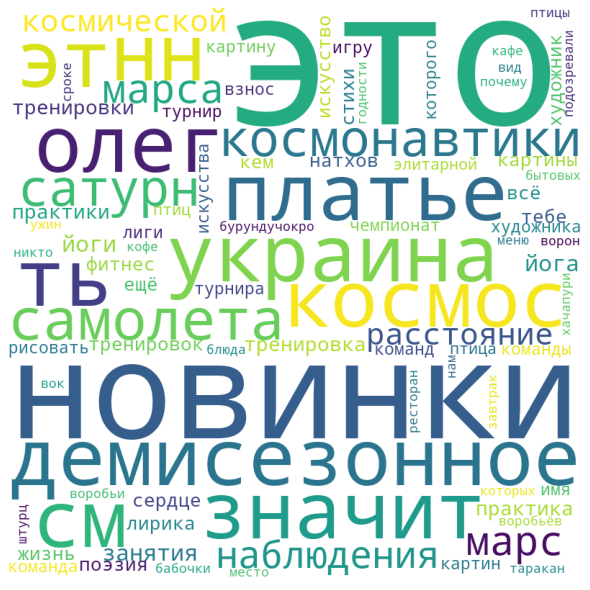

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

USER_IDX = 0

user_num = posts_df_prep.user_id.unique()[USER_IDX]
words = []

for row in tqdm(posts_df_prep[posts_df_prep.user_id == user_num].itertuples()):
    if row.topic_num < 0: continue
    words.extend(word for word, _ in topic_model.get_topic(topic=row.topic_num))

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      min_font_size = 10)\
                .generate(' '.join(words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Профиль пользователя по годовым интервалам

,Topic,Count,Name
4,3,384,3_новинки_демисезонное_платье_украина
9,8,271,8_всё_тебе_сердце_стихи
18,17,222,17_это_космос_самолета_космонавтики
20,19,221,19_подозревали_сроке_годности_бытовых
25,24,213,24_турнир_команда_команды_команд
28,27,201,27_картины_художник_искусство_художника
39,38,158,38_кофе_кафе_ужин_ресторан
43,42,152,42_птица_птиц_бурундучокро_воробьёв
48,47,133,47_йога_йоги_занятия_тренировка


  0%|          | 0/4 [00:00<?, ?it/s]

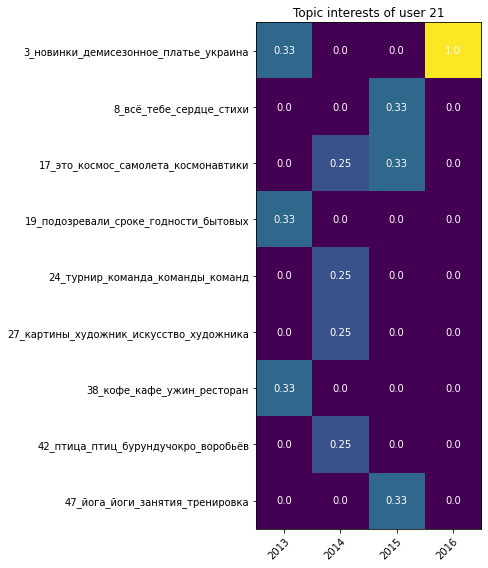

In [75]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 8)

USER_IDX = 0

user_num = posts_df_prep.user_id.unique()[USER_IDX]
user_posts_df = posts_df_prep[posts_df_prep.user_id == user_num]
min_year = user_posts_df.date.dt.year.min()
max_year = user_posts_df.date.dt.year.max()

topics = np.zeros((len(topic_model.get_topics()) - 1, max_year + 1 - min_year))

for year in tqdm(range(min_year, max_year + 1)):
    for row in user_posts_df[user_posts_df.date.dt.year == year].itertuples():
        if row.topic_num < 0: continue
        topics[row.topic_num, year - min_year] += 1

idxs = np.argwhere(topics.sum(axis=1) > 0).reshape(-1)

topics = topics[idxs]

topics /= topics.sum(axis=0)
topics = np.nan_to_num(topics)

fig, ax = plt.subplots()
im = ax.imshow(topics)

# We want to show all ticks...
ax.set_xticks(np.arange(topics.shape[1]))
ax.set_yticks(np.arange(topics.shape[0]))

# ... and label them with the respective list entries
xlabels = list(range(min_year, max_year + 1))

topic_info = topic_model.get_topic_info()
ylabels = topic_info[topic_info.Topic.isin(idxs)].Name

ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(topics.shape[0]):
    for j in range(topics.shape[1]):
        text = ax.text(j, i, np.around(topics[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title(f"Topic interests of user {user_num}")
fig.tight_layout()
plt.show()